In [1]:
import networkx as nx
from regraph import Rule, plot_rule


from regraph.neo4j.hierarchy import Neo4jHierarchy
import regraph.neo4j.cypher_utils as cypher

In [2]:
# initialize the neo4j driver, wrappped into Neo4jHierarchy object
h = Neo4jHierarchy(uri="bolt://localhost:7687", user="neo4j", password="admin")
h._clear()

## Add the default components to the KAMI hierarchy

In [3]:
nodes = ["gene", "region", "state", "mod", "bnd"]

edges = [
    ("gene", "mod"),
    ("gene", "bnd"),
    ("region", "gene"),
    ("region", "mod"),
    ("region", "bnd"),
    ("state", "gene"),
    ("state", "region"),
    ("mod", "state")
]
h.add_graph('meta_model', nodes, edges)

CREATE CONSTRAINT ON (n:meta_model) ASSERT n.id IS UNIQUE
OPTIONAL MATCH (same_id_node:meta_model) 
WHERE same_id_node.id = 'gene' 
FOREACH(new_count 
	IN CASE WHEN same_id_node IS NOT NULL
	THEN [coalesce(same_id_node.count, 0) + 1]
	ELSE [] END | 
		SET same_id_node.count = new_count) 
WITH same_id_node 
UNWIND
	CASE WHEN same_id_node IS NOT NULL
	THEN ['gene' + same_id_node.count]
	ELSE ['gene'] END AS new_id_gene 
		CREATE (gene:meta_model { id : new_id_gene }) 
WITH gene, new_id_gene OPTIONAL MATCH (same_id_node:meta_model) 
WHERE same_id_node.id = 'region' 
FOREACH(new_count 
	IN CASE WHEN same_id_node IS NOT NULL
	THEN [coalesce(same_id_node.count, 0) + 1]
	ELSE [] END | 
		SET same_id_node.count = new_count) 
WITH same_id_node 
UNWIND
	CASE WHEN same_id_node IS NOT NULL
	THEN ['region' + same_id_node.count]
	ELSE ['region'] END AS new_id_region 
		CREATE (region:meta_model { id : new_id_region }) 
WITH new_id_region, region OPTIONAL MATCH (same_id_node:meta_model) 
WHERE same_i

In [4]:
h.add_graph('action_graph', [], [])
h.add_typing("action_graph", "meta_model", {})

CREATE CONSTRAINT ON (n:action_graph) ASSERT n.id IS UNIQUE

CREATE CONSTRAINT ON (n:action_graph) ASSERT n.id IS UNIQUE
CREATE CONSTRAINT ON (n:meta_model) ASSERT n.id IS UNIQUE


## Aggregation use-case / (controlled) down-propagation

### 1) Add two empty nuggets typed by the action graph

In [5]:
h.add_graph("nugget_1", [], [])
h.add_typing("nugget_1", "action_graph", {})
h.add_graph("nugget_2", [], [])
h.add_typing("nugget_2", "action_graph", {})

CREATE CONSTRAINT ON (n:nugget_1) ASSERT n.id IS UNIQUE

CREATE CONSTRAINT ON (n:nugget_1) ASSERT n.id IS UNIQUE
CREATE CONSTRAINT ON (n:action_graph) ASSERT n.id IS UNIQUE
CREATE CONSTRAINT ON (n:nugget_2) ASSERT n.id IS UNIQUE

CREATE CONSTRAINT ON (n:nugget_2) ASSERT n.id IS UNIQUE
CREATE CONSTRAINT ON (n:action_graph) ASSERT n.id IS UNIQUE


### 1) Generation rule for nugget 1 (none of the nodes are typed)

/home/eugenia/anaconda3/envs/regraph_v2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


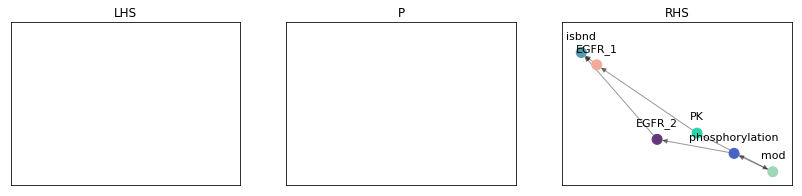

In [6]:
rule1 = Rule.from_transform(nx.DiGraph())
# inject node addition
rule1.inject_add_nodes_from([
    ("EGFR_1", {"uniprotid": "P00533"}),
    ("EGFR_2", {"uniprotid": "P00533"}),
    ("isbnd", {"type": "be", "test": True}),
    ("PK", {"name": "Protein kinase"}),
    ("mod", {"value": True}),
    ("phosphorylation", {"name": "phosphorylation", "test": False})
])
rule1.inject_add_edges_from([
    ("EGFR_1", "isbnd"),
    ("EGFR_2", "isbnd"),
    ("PK", "EGFR_1", {"start": 100, "end": 600}),
    ("PK", "mod"),
    ("mod", "phosphorylation"),
    ("phosphorylation", "EGFR_2")
])

plot_rule(rule1)

In [7]:
rhs_typing1 = {
    "meta_model": {
        "EGFR_1": "gene",
        "EGFR_2": "gene",
        "PK": "region",
        "phosphorylation": "state",
        "isbnd": "bnd",
        "mod": "mod"
    }
}

In [8]:
_, rhs_g1 = h.rewrite("nugget_1", rule1, {}, rhs_typing=rhs_typing1)

CREATE CONSTRAINT ON (n:nugget_1) ASSERT n.id IS UNIQUE
// Empty instance 

// Adding node 'phosphorylation' from the rhs 
CREATE (rhs_phosphorylation:nugget_1) 
SET rhs_phosphorylation.id = toString(id(rhs_phosphorylation)) 
WITH toString(id(rhs_phosphorylation)) as rhs_phosphorylation_id , rhs_phosphorylation


// Adding node 'EGFR_1' from the rhs 
CREATE (rhs_EGFR_1:nugget_1) 
SET rhs_EGFR_1.id = toString(id(rhs_EGFR_1)) 
WITH toString(id(rhs_EGFR_1)) as rhs_EGFR_1_id , rhs_phosphorylation_id, rhs_phosphorylation, rhs_EGFR_1


// Adding node 'PK' from the rhs 
CREATE (rhs_PK:nugget_1) 
SET rhs_PK.id = toString(id(rhs_PK)) 
WITH toString(id(rhs_PK)) as rhs_PK_id , rhs_EGFR_1_id, rhs_phosphorylation, rhs_EGFR_1, rhs_PK, rhs_phosphorylation_id


// Adding node 'EGFR_2' from the rhs 
CREATE (rhs_EGFR_2:nugget_1) 
SET rhs_EGFR_2.id = toString(id(rhs_EGFR_2)) 
WITH toString(id(rhs_EGFR_2)) as rhs_EGFR_2_id , rhs_PK_id, rhs_EGFR_1_id, rhs_phosphorylation, rhs_EGFR_1, rhs_PK, rhs_phosphoryl

### 3) Merge two nodes in the action graph (to avoid gene duplication)

/home/eugenia/anaconda3/envs/regraph_v2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


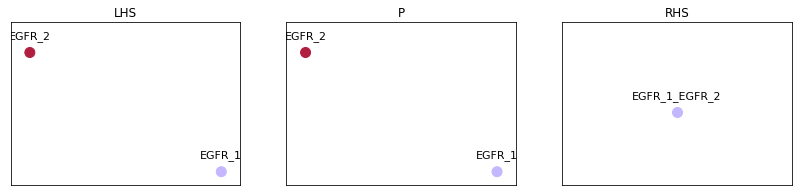

In [9]:
pattern = nx.DiGraph()
pattern.add_nodes_from([
    "EGFR_1", "EGFR_2"
])

rule2 = Rule.from_transform(pattern)
merge_result_id = rule2.inject_merge_nodes(["EGFR_1", "EGFR_2"])
plot_rule(rule2)

In [10]:
action_graph_EGFR_1 = h.node_type("nugget_1", rhs_g1["EGFR_1"])["action_graph"]
action_graph_EGFR_2 = h.node_type("nugget_1", rhs_g1["EGFR_2"])["action_graph"]
_, rhs_g2 = h.rewrite(
    "action_graph", rule2, 
    {"EGFR_1": str(action_graph_EGFR_1), "EGFR_2": str(action_graph_EGFR_2)})
action_graph_EGFR = rhs_g2[merge_result_id]

CREATE CONSTRAINT ON (n:action_graph) ASSERT n.id IS UNIQUE
// Match nodes and edges of the instance 
MATCH (lhs_EGFR_1:action_graph { id : '166364'}) , (lhs_EGFR_2:action_graph { id : '166375'})  



// Renaming vars to correspond to the vars of P
WITH lhs_EGFR_1 as p_EGFR_1, lhs_EGFR_2 as p_EGFR_2 

// Merging nodes '{'EGFR_2', 'EGFR_1'}' of the preserved part into 'EGFR_1_EGFR_2' 
// accumulate all the attrs of the nodes to be merged
WITH [] as new_props, p_EGFR_2, p_EGFR_1
WITH new_props + REDUCE(pairs = [], k in keys(p_EGFR_2) | 
	pairs + REDUCE(inner_pairs = [], v in p_EGFR_2[k] | 
		inner_pairs + {key: k, value: v})) as new_props, p_EGFR_2, p_EGFR_1
WITH new_props + REDUCE(pairs = [], k in keys(p_EGFR_1) | 
	pairs + REDUCE(inner_pairs = [], v in p_EGFR_1[k] | 
		inner_pairs + {key: k, value: v})) as new_props, p_EGFR_2, p_EGFR_1
WITH apoc.map.groupByMulti(new_props, 'key') as new_props, p_EGFR_2, p_EGFR_1
WITH apoc.map.fromValues(REDUCE(pairs=[], k in keys(new_props) | 
	pairs +

### 4) Generation rule for nugget 2 (some of the nodes are already in the action graph)

/home/eugenia/anaconda3/envs/regraph_v2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


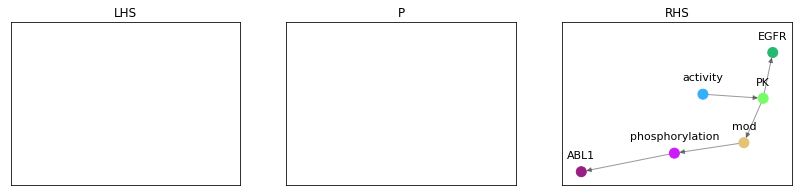

In [11]:
# Rule that merges two EGFR nodes from the action graph
rule3 = Rule.from_transform(nx.DiGraph())
rule3.inject_add_nodes_from([
    ("EGFR", {"uniprotid": "P00533", "hgnc_symbol": "EGFR"}),
    ("PK", {"name": "Protein kinase"}),
    ("activity", {"name": "activity", "test": True}),
    ("mod", {"value": True}),
    ("phosphorylation", {"name": "phosphorylation", "test": False}),
    ("ABL1", {"uniprotid": "P00519", "hgnc_symbol": "ABL1"})
])
rule3.inject_add_edges_from([
    ("PK", "EGFR", {"start": 300, "end": 500}),
    ("activity", "PK"),
    ("PK", "mod"),
    ("mod", "phosphorylation"),
    ("phosphorylation", "ABL1")
])
plot_rule(rule3)

In [12]:
action_graph_PK = h.node_type("nugget_1", rhs_g1["PK"])["action_graph"]

rhs_typing3 = {
    "action_graph": {
        "EGFR": action_graph_EGFR,
        "PK": action_graph_PK
    },
    "meta_model": {
        "activity": "state",
        "mod": "mod",
        "phosphorylation": "state",
        "ABL1": "gene"
    }
}
print(rhs_typing3)

{'action_graph': {'EGFR': '166375', 'PK': '166366'}, 'meta_model': {'activity': 'state', 'mod': 'mod', 'phosphorylation': 'state', 'ABL1': 'gene'}}


In [13]:
_, rhs_g3 = h.rewrite("nugget_2", rule3, {}, rhs_typing=rhs_typing3)

CREATE CONSTRAINT ON (n:nugget_2) ASSERT n.id IS UNIQUE
// Empty instance 

// Adding node 'phosphorylation' from the rhs 
CREATE (rhs_phosphorylation:nugget_2) 
SET rhs_phosphorylation.id = toString(id(rhs_phosphorylation)) 
WITH toString(id(rhs_phosphorylation)) as rhs_phosphorylation_id , rhs_phosphorylation


// Adding node 'ABL1' from the rhs 
CREATE (rhs_ABL1:nugget_2) 
SET rhs_ABL1.id = toString(id(rhs_ABL1)) 
WITH toString(id(rhs_ABL1)) as rhs_ABL1_id , rhs_phosphorylation_id, rhs_phosphorylation, rhs_ABL1


// Adding node 'PK' from the rhs 
CREATE (rhs_PK:nugget_2) 
SET rhs_PK.id = toString(id(rhs_PK)) 
WITH toString(id(rhs_PK)) as rhs_PK_id , rhs_ABL1_id, rhs_ABL1, rhs_phosphorylation, rhs_PK, rhs_phosphorylation_id


// Adding node 'activity' from the rhs 
CREATE (rhs_activity:nugget_2) 
SET rhs_activity.id = toString(id(rhs_activity)) 
WITH toString(id(rhs_activity)) as rhs_activity_id , rhs_PK_id, rhs_ABL1_id, rhs_ABL1, rhs_phosphorylation, rhs_PK, rhs_phosphorylation_id, 

### 5) Merge two modification actions of a protein kinase region in the action graph

/home/eugenia/anaconda3/envs/regraph_v2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


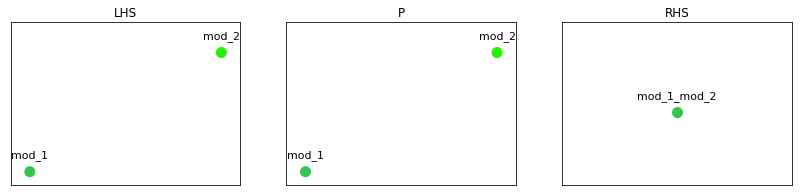

In [14]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["mod_1", "mod_2"])
rule4 = Rule.from_transform(pattern)
merged_mod = rule4.inject_merge_nodes(["mod_1", "mod_2"])
plot_rule(rule4)

In [15]:
action_graph_mod_1 = h.node_type("nugget_1", rhs_g1["mod"])["action_graph"]
action_graph_mod_2 = h.node_type("nugget_2", rhs_g3["mod"])["action_graph"]
_, rhs_g4 = h.rewrite(
    "action_graph", rule4, 
    {"mod_1": str(action_graph_mod_1), "mod_2": str(action_graph_mod_2)})


CREATE CONSTRAINT ON (n:action_graph) ASSERT n.id IS UNIQUE
// Match nodes and edges of the instance 
MATCH (lhs_mod_1:action_graph { id : '166362'}) , (lhs_mod_2:action_graph { id : '166381'})  



// Renaming vars to correspond to the vars of P
WITH lhs_mod_1 as p_mod_1, lhs_mod_2 as p_mod_2 

// Merging nodes '{'mod_1', 'mod_2'}' of the preserved part into 'mod_1_mod_2' 
// accumulate all the attrs of the nodes to be merged
WITH [] as new_props, p_mod_2, p_mod_1
WITH new_props + REDUCE(pairs = [], k in keys(p_mod_1) | 
	pairs + REDUCE(inner_pairs = [], v in p_mod_1[k] | 
		inner_pairs + {key: k, value: v})) as new_props, p_mod_2, p_mod_1
WITH new_props + REDUCE(pairs = [], k in keys(p_mod_2) | 
	pairs + REDUCE(inner_pairs = [], v in p_mod_2[k] | 
		inner_pairs + {key: k, value: v})) as new_props, p_mod_2, p_mod_1
WITH apoc.map.groupByMulti(new_props, 'key') as new_props, p_mod_2, p_mod_1
WITH apoc.map.fromValues(REDUCE(pairs=[], k in keys(new_props) | 
	pairs + [k, REDUCE(values=[],

## Instantiation use-case / up-propagation

/home/eugenia/anaconda3/envs/regraph_v2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


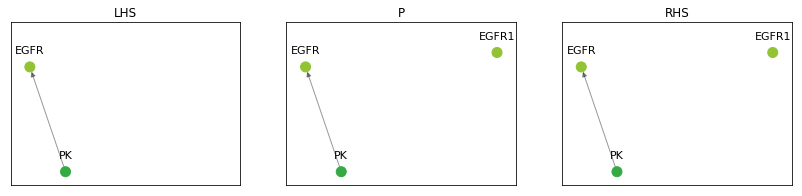

In [16]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["EGFR", "PK"])
pattern.add_edges_from([("PK", "EGFR")])
rule5 = Rule.from_transform(pattern)
_, cloned_node = rule5.inject_clone_node("EGFR")
rule5.inject_remove_edge("PK", cloned_node)

plot_rule(rule5)

In [17]:
rhs_g5 = h.rewrite(
    "action_graph", rule5, 
    {"EGFR": action_graph_EGFR, "PK": action_graph_PK})

CREATE CONSTRAINT ON (n:action_graph) ASSERT n.id IS UNIQUE
// Match nodes and edges of the instance 
MATCH (lhs_EGFR:action_graph { id : '166375'}) , (lhs_PK:action_graph { id : '166366'})  , (lhs_PK)-[lhs_PK_lhs_EGFR:edge]->(lhs_EGFR)

// Cloning node 'EGFR' of the lhs 
// Create clone corresponding to 'EGFR1' of the preserved part
// create a node corresponding to the clone
CREATE (p_EGFR1:action_graph) 
WITH p_EGFR1, toString(id(p_EGFR1)) as p_EGFR1_id, lhs_EGFR.id as original_old, lhs_EGFR, lhs_PK, lhs_PK_lhs_EGFR 
// set the id property of the original node to NULL
SET lhs_EGFR.id = NULL
// copy all the properties of the original node to the clone
SET p_EGFR1 = lhs_EGFR
// set id property of the clone to neo4j-generated id
SET p_EGFR1.id = toString(id(p_EGFR1)), p_EGFR1.count = NULL
// set back the id property of the original node
SET lhs_EGFR.id = original_old
WITH p_EGFR1, toString(id(p_EGFR1)) as p_EGFR1_id, lhs_EGFR, lhs_PK, lhs_PK_lhs_EGFR 
WITH [] as sucIgnore, ['166366'] a